# #Part 1- Sentiment

# 1. Problem Statement


The reviews that a videogame recieves on steam is related with the amount of attention it recieves from the steam community. On the Steam reviews site, a user can either recommend the game or not recommend the game, this is very ambiguous to the degree that a reviewer makes their decision, there are no numerical representations of rating, it is a black and white rating of whether or not they recommend the game to the other users of the Steam community. 

The success of a videogame overall is definetly related to the sentiment of the reviews it recieves. In this notebook, I will attempt to determine a relationship between the sentiment of a review, and the amount of time that reviewer has played the videogame after reviewing it. In theory, the more positive someone's review would reflect how much they play in the future after posting that review.

In [30]:
import pandas as pd
import numpy as np
import pickle
import math
import json
import requests
import nltk
import matplotlib
import unirest
import datetime
import patsy
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from collections import defaultdict
from requests import get
from string import find, digits
from textblob import TextBlob

from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import grid_search
from sklearn.preprocessing import StandardScaler

from gensim import corpora, models, matutils
from nltk.corpus import stopwords

import valve.steam.id as sid
from lxml import html


%matplotlib inline

In [2]:
#Reading in the data
dota = '../Raw Data/Dota_2.jsonlines.txt'
elder = '../Raw Data/The_Elder_Scrolls_V.jsonlines.txt' 
tf2 = '../Raw Data/Team_Fortress_2.jsonlines.txt'
civ = '../Raw Data/Sid_Meiers_Civilization_5.jsonlines.txt'
gta = '../Raw Data/Grand_Theft_Auto_V.jsonlines.txt'
gmod = '../Raw Data/Garrys_Mod.jsonlines.txt'
fbm = '../Raw Data/Football_Manager_2015.jsonlines.txt'
csgo = '../Raw Data/Counter_Strike_Global_Offensive.jsonlines.txt'
cs = '../Raw Data/Counter_Strike.jsonlines.json'
warframe = '../Raw Data/Warframe.jsonlines.txt'
arma = '../Raw Data/Arma_3.jsonlines.json'

dota_data = []
with open(dota) as data_file:
    for line in data_file:
        dota_data.append(json.loads(line))
elder_data = []
with open(elder) as data_file:
    for line in data_file:
        elder_data.append(json.loads(line))
tf2_data = []
with open(tf2) as data_file:
    for line in data_file:
        tf2_data.append(json.loads(line))
civ_data = []        
with open(civ) as data_file:
    for line in data_file:
        civ_data.append(json.loads(line))
gta_data = []       
with open(gta) as data_file:
    for line in data_file:
        gta_data.append(json.loads(line))
gmod_data = []        
with open(gmod) as data_file:
    for line in data_file:
        gmod_data.append(json.loads(line))
fbm_data = []        
with open(fbm) as data_file:
    for line in data_file:
        fbm_data.append(json.loads(line))
csgo_data = []        
with open(csgo) as data_file:
    for line in data_file:
        csgo_data.append(json.loads(line))
cs_data = []        
with open(cs) as data_file:
    for line in data_file:
        cs_data.append(json.loads(line))
warframe_data = []      
with open(warframe) as data_file:
    for line in data_file:
        warframe_data.append(json.loads(line))
arma_data = []        
with open(arma) as data_file:
    for line in data_file:
        arma_data.append(json.loads(line))
        
dota_df = pd.DataFrame(dota_data)
print "Shape of dota data = ", dota_df.shape
elder_df = pd.DataFrame(elder_data)
print "Shape of elderscrolls data = ", elder_df.shape
tf2_df = pd.DataFrame(tf2_data)
print "Shape of tf2 data = ",tf2_df.shape
civ_df = pd.DataFrame(civ_data)
print "Shape of civ data = ", civ_df.shape
gta_df = pd.DataFrame(gta_data)
print "Shape of gta data = ", gta_df.shape
gmod_df = pd.DataFrame(gmod_data)
print "Shape of gmod data = ", gmod_df.shape
fbm_df = pd.DataFrame(fbm_data)
print "Shape of football manager data = ", fbm_df.shape
csgo_df = pd.DataFrame(csgo_data)
print "Shape of csgo data = ", csgo_df.shape
cs_df = pd.DataFrame(cs_data)
print "Shape of cs data = ", cs_df.shape
warframe_df = pd.DataFrame(warframe_data)
print "Shape of warframe data = ", warframe_df.shape
arma_df = pd.DataFrame(arma_data)
print "Shape of arma data = ", arma_df.shape

Shape of dota data =  (9720, 27)
Shape of elderscrolls data =  (7165, 27)
Shape of tf2 data =  (5676, 27)
Shape of civ data =  (7467, 27)
Shape of gta data =  (13349, 27)
Shape of gmod data =  (7151, 27)
Shape of football manager data =  (1522, 27)
Shape of csgo data =  (7073, 27)
Shape of cs data =  (6040, 27)
Shape of warframe data =  (7123, 27)
Shape of arma data =  (7151, 27)


# 2. Description of Data

The data I used was obtained from a github user who was trying to predict user experience based on the reviews they scraped.

From this repo: https://github.com/mulhod/steam_reviews

The games used for analysis:

Counter Strike 1.6

Counter-Strike Global Offensive

Warframe

ArmA 3

Garry's Mod

Grand Theft Auto 5

Sid Mier's Civilization 5

Team Fortress 2

Skyrim: The Elder Scrolls

DotA 2

The data consists of 28 columns:
u'achievement_progress' - three part  dictionary containing amount of possible achievements across games, amount of
achievements earned, and a percent representation of completion


Columns:
==================================================================

u'date_posted' - Timestamp representing the date at which the reviewer posted the review

u'date_updated' - Timestamp representing the most recent date at which the reviewer updated the review

u'found_helpful_percentage' - Percent representation of users who found the review helpful out of all users who voted that it was helpful or unhelpful

u'friend_player_level' - A level assigned to a player based on the amount of friends they have. 

u'num_badges' - Number of Steam profile badges the user has accumulated

u'num_comments' - Number of comments on the review

u'num_found_funny' - Number of users who found the review funny

u'num_found_helpful' - Number of users who found the review helpful

u'num_found_unhelpful' - Number of users who found the review unhelpful

u'num_friends' - Number of friends the reviewer had

u'num_games_owned' - Number of games the reviewer owns

u'num_groups' - Number of groups the reviewer is a member of

u'num_guides' - Number of video-game guides the reviewer has created

u'num_reviews' - Number of reviews the reviewer has posted

u'num_screenshots' - Number of screenshots the reviewer has taken

u'num_voted_helpfulness' - Number of users who found the review helpful

u'num_workshop_items' - Number of workshop items the reviewer has created

u'orig_url'- Original URL of review   

u'profile_url' - Reviewer profile URL

u'rating' - Rating the reviewer gave the game either recommending the game, or not recommending the game

u'review' - Full body of review text

u'review_url' - URL corresponding to the review

u'steam_id_number' - 64-Bit Steam-ID number

u'total_game_hours' - Summative amount of hours game has been played

u'total_game_hours_last_two_weeks' - Total hours reviewer has played reviewed videogame in the past two weeks

u'username' - The user alias that in some cases, is part of the profile_URL               


In [3]:
dota_df.describe()

/home/dsi-student/anaconda2/envs/dsi/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,found_helpful_percentage,friend_player_level,num_badges,num_comments,num_found_funny,num_found_helpful,num_found_unhelpful,num_friends,num_games_owned,num_groups,num_guides,num_reviews,num_screenshots,num_voted_helpfulness,num_workshop_items,total_game_hours,total_game_hours_last_two_weeks
count,6261.000000,8450.000000,8449.000000,9720.000000,9720.000000,9720.000000,9720.000000,8415.000000,9720.000000,7714.000000,9720.000000,9720.000000,9720.000000,9720.000000,9720.000000,9720.000000,9720.000000
mean,0.912862,13.450533,13.374601,2.544959,0.781893,127.684877,14.394444,99.462864,70.657099,17.259398,0.434979,4.554424,77.917387,142.079321,0.290947,1546.518498,22.134414
std,0.123872,15.663591,32.156628,14.278060,4.282873,898.880675,91.700310,91.948994,165.792327,46.430237,3.117728,11.129175,368.838445,988.947794,3.391236,1481.526089,34.707354
min,0.525000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,2.000000,NaN,0.000000,1.000000,0.000000,0.000000,0.000000,569.450000,0.000000
50%,NaN,NaN,NaN,0.000000,1.000000,2.000000,0.000000,NaN,16.000000,NaN,0.000000,1.000000,4.000000,2.000000,0.000000,1245.900000,7.200000
75%,NaN,NaN,NaN,1.000000,1.000000,3.000000,0.000000,NaN,76.000000,NaN,0.000000,4.000000,29.000000,4.000000,0.000000,2118.125000,32.600000
max,1.000000,475.000000,1569.000000,260.000000,150.000000,13614.000000,1330.000000,1542.000000,3408.000000,1412.000000,145.000000,266.000000,10808.000000,14944.000000,191.000000,16434.800000,325.100000


The data was fairly clean to begin with.

In [4]:
dota_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9720 entries, 0 to 9719
Data columns (total 27 columns):
achievement_progress               9720 non-null object
date_posted                        9720 non-null object
date_updated                       1407 non-null object
found_helpful_percentage           6261 non-null float64
friend_player_level                8450 non-null float64
num_badges                         8449 non-null float64
num_comments                       9720 non-null int64
num_found_funny                    9720 non-null int64
num_found_helpful                  9720 non-null int64
num_found_unhelpful                9720 non-null int64
num_friends                        8415 non-null float64
num_games_owned                    9720 non-null int64
num_groups                         7714 non-null float64
num_guides                         9720 non-null int64
num_reviews                        9720 non-null int64
num_screenshots                    9720 non-null int64


# 3. Cleaning

In [61]:
game_dfs = [dota_df, elder_df, tf2_df, civ_df, 
            gta_df, gmod_df, fbm_df, csgo_df, 
            cs_df, warframe_df, arma_df]

The step above is so I can do feature operations on all of the game dataframes at once.

Below, so that I can reference the specific game IDs on the fly while fetching the hours played from the steam web API

In [ ]:
for x in game_dfs:
    x['textblobobj'] = x['review'].map(TextBlob)
    x['sentiment'] = x['textblobobj'].map(lambda z: z.sentiment[0])
    x['subjectivity'] = x['textblobobj'].map(lambda z: z.sentiment[1])

In [64]:
dota_df['game_id'], dota_df['gamename'] = (570, 'DotA2')
elder_df['game_id'], elder_df['gamename'] = (72850, 'Skyrim: The Elder Scrolls')
tf2_df['game_id'], tf2_df['gamename'] = (440, 'Team Fortress: 2')
civ_df['game_id'], civ_df['gamename'] = (8930, "Sid Mier's Civilization: V")
gta_df['game_id'], gta_df['gamename'] = (271590, 'Grand Theft Auto: V')
gmod_df['game_id'], gmod_df['gamename'] = (4000, "Garry's Mod")
fbm_df['game_id'], fbm_df['gamename'] = (295270, 'Football Manager: 2015')
csgo_df['game_id'], csgo_df['gamename'] = (730, 'Counter-Strike: Global Offensive')
cs_df['game_id'], cs_df['gamename'] = (10, 'Counter-Strike: 1.6')
warframe_df['game_id'], warframe_df['gamename'] = (230410, 'Warframe')
arma_df['game_id'], arma_df['gamename'] = (107410, 'ArmA: 3')

The following cell is the class used to convert the steam vanity URLs to steam IDs, which I could then use for the Steam web API

In [7]:
BASE = long(76561197960265728)
PREFIX = 'U:1:'
STEAM_COMMUNITY = 'http://steamcommunity.com/id/'
STEAM_API_KEY = '9322F9CA7232748D973D043702070B16'


########################################
# Class Courtesy of:                   #
# https://github.com/annasapek/steamid #
########################################
class NoSuchSteamIDError(Exception):
    pass

def get_64bit_steam_id(vanityurl):
    """ Retrieves the 64-bit Steam ID for the given vanity url
        eg. http://steamcommunity.com/id/vanityurl -> xxxxxxxxxxxxxxxxx
    
    """
    
    if vanityurl.startswith(STEAM_COMMUNITY):
        vanityurl = vanityurl[len(STEAM_COMMUNITY):]
    
    RESOLVE_VANITY_URL = \
        'http://api.steampowered.com/ISteamUser/ResolveVanityURL/v0001/?key=%s&vanityurl=%s'
    if vanityurl == None:
        raise ValueError('Must provide vanityurl')
        exit(1)
    else:
        result = get(RESOLVE_VANITY_URL % (STEAM_API_KEY, vanityurl))
        if result.status_code == 403:
            raise ValueError('Invalid Steam API key: %s' % STEAM_API_KEY)
        else:
            result.raise_for_status()
            data = result.json()
            if data['response']['success'] == 1:
                return data['response']['steamid']
            else:
                raise NoSuchSteamIDError('Could not resolve vanity url: %s' % vanityurl)
                exit(1)

def get_32bit_steam_id(vanityurl):
    """ Retrieves the 32-bit Steam ID for the given vanity url
        eg. http://steamcommunity.com/id/vanityurl -> U:1:XXXXXXXX
    
    """
    
    steam_id = long(get_64bit_steam_id(vanityurl))
    return 'U:1:%s' % (steam_id - BASE)

def convert_32bit_to_64bit(steamid):
    """ Given a valid 32-bit Steam ID, in the form U:1:XXXXXX or XXXXXX, returns the 
        equivalent 64-bit Steam ID in the form xxxxxxxxxxxxxxxxx
    """
    
    u_index = find(str(steamid), PREFIX)
    if u_index != -1:
        steamid = steamid[u_index + len(PREFIX):]
    validate_id_number(steamid)
    return str(long(steamid) + BASE)

def convert_64bit_to_32bit(steamid):
    """ Given a valid 64-bit Steam ID, in the form xxxxxxxxxxxxxxxxx, returns the 
        equivalent 32-bit Steam ID in the form U:1:XXXXXX
    """
    
    validate_id_number(steamid)
    return 'U:1:%s' % (long(steamid) - BASE)

def validate_id_number(value):
    """ Given an id number, returns true if it only contains digits
    """
    
    for char in str(value):
        if char not in digits:
            raise ValueError('%s is not a valid number' % value)

clean_df_profile_url() takes  the dataframe I pass and traverses the Steam ID column, creating a new column, 'parsed_steam_ids'

In [8]:
#Based on a "vanity" URL (URL: http://steamcommunity.com/id/<your alias>/), return the steam ID, if unretrievable, return NaN
def clean_df_profile_url(passed_df):
    game_id = passed_df.ix[0, 'game_id']
    #For each row, steamURL in passed_df
    for i, steam_url in enumerate(passed_df['profile_url']):
        try:
            # Try to fetch the steam ID
            steam_id = get_64bit_steam_id(str(steam_url))
            passed_df.ix[i, 'parsed_steam_ids'] = steam_id
        except:
            # If unretrievable set passed_df.ix[row, parsed_steam_ids] to NaN
            passed_df.ix[i, 'parsed_steam_ids'] = np.nan
    print game_id
    filepath = '../capstone/' + str(game_id) +'.pkl'
    pd.to_pickle(passed_df, filepath)
    print 'saved: ', filepath

The following method makes calls to the steam web API and fetches the hours played for each player in each data frame of which I was able to get a corresponding steam ID for.

In [9]:
def fetch_hours_played(passed_df):
    # Specific identifier for the game being parsed
    game_id = passed_df.ix[0, 'game_id']
    #For each row, steam ID available in passed_df
    for i, steam_id_ in enumerate(passed_df['parsed_steam_ids']):
        requestlink = 'http://api.steampowered.com/IPlayerService/GetOwnedGames/v0001?key=9322F9CA7232748D973D043702070B16&steamid='+ \
        str(steam_id_) + '&include_played_free_games=1&format=json'
        #If steam ID pulled from the dataframe is not a NaN
        if 'nan' not in requestlink:
            stats = requests.get(requestlink)
            content = stats.content
            formatted = json.loads(content)
            try:
                # For all games listed in JSON response, this encompasses all games for a steam user
                for x in formatted['response']['games']:
                    if x['appid'] == game_id:
                        passed_df.ix[i, 'hours_played_now'] = x['playtime_forever']
            except:
                #If the game reviwed was not found, set passed_df.ix[row, 'hours_played_now'] to nan
                passed_df.ix[i, 'hours_played_now'] =  np.nan
        else:
            #If the steam ID was a nan, set passed_df.ix[row, 'hours_played_now'] to nan
            passed_df.ix[i, 'hours_played_now'] = np.nan
    #Save a file specific to the game ID of the dataframe being traversed
    filepath = '../capstone/final_' + str(game_id) +'.pkl'
    pd.to_pickle(passed_df, filepath)
    print 'saved_final: ', filepath

The fetching process was very time consuming, in order to munge this column and prevent myself from having to traverse the dataframe all over again each time I want to do analysis, each time it reaches the end of a dataframe.

In [10]:
# After getting steam ids and time played, pickled files:
dota_with_time = pd.read_pickle('../Cleaned Data/final_570.pkl')
elder_with_time = pd.read_pickle('../Cleaned Data/final_72850.pkl')
tf2_with_time = pd.read_pickle('../Cleaned Data/final_440.pkl')
civ_with_time = pd.read_pickle('../Cleaned Data/final_8930.pkl')
gta_with_time = pd.read_pickle('../Cleaned Data/final_271590.pkl')
gmod_with_time = pd.read_pickle('../Cleaned Data/final_4000.pkl')
fbm_with_time = pd.read_pickle('../Cleaned Data/final_295270.pkl')
csgo_with_time = pd.read_pickle('../Cleaned Data/final_730.pkl')
cs_with_time = pd.read_pickle('../Cleaned Data/final_10.pkl')
warframe_with_time = pd.read_pickle('../Cleaned Data/final_230410.pkl')
arma_with_time = pd.read_pickle('../Cleaned Data/final_107410.pkl')

In [11]:
#Subset data by items that have non-null values for the column pulled from the steam web API
#In my cleaning function any time that the data couldnt be fetched i replaced that data with a NaN
dota_with_time_nonan = dota_with_time[pd.notnull(dota_with_time['hours_played_now'])]
elder_with_time_nonan = elder_with_time[pd.notnull(elder_with_time['hours_played_now'])]
tf2_with_time_nonan = tf2_with_time[pd.notnull(tf2_with_time['hours_played_now'])]
civ_with_time_nonan = civ_with_time[pd.notnull(civ_with_time['hours_played_now'])]
gta_with_time_nonan = gta_with_time[pd.notnull(gta_with_time['hours_played_now'])]
fbm_with_time_nonan = fbm_with_time[pd.notnull(fbm_with_time['hours_played_now'])]
gmod_with_time_nonan = gmod_with_time[pd.notnull(gmod_with_time['hours_played_now'])]
csgo_with_time_nonan = csgo_with_time[pd.notnull(csgo_with_time['hours_played_now'])]
cs_with_time_nonan = cs_with_time[pd.notnull(cs_with_time['hours_played_now'])]
warframe_with_time_nonan = warframe_with_time[pd.notnull(warframe_with_time['hours_played_now'])]
arma_with_time_nonan = arma_with_time[pd.notnull(arma_with_time['hours_played_now'])]

In [12]:
cleaned_dfs = [dota_with_time_nonan,  elder_with_time_nonan, tf2_with_time_nonan,
              fbm_with_time_nonan, gta_with_time_nonan, civ_with_time_nonan, 
              gmod_with_time_nonan, csgo_with_time_nonan, cs_with_time_nonan, 
              arma_with_time_nonan, warframe_with_time_nonan]

In [13]:
for x in cleaned_dfs:
    # Hours played gets returned from the steam web API in minutes
    x['hours_played_now'] = x['hours_played_now']/ 60.
    # Difference in hours played
    x['hours_played_diff'] = x['hours_played_now'] - x['total_game_hours']
    # For timeseries analysis
    x['date_posted'] = pd.to_datetime(x['date_posted'])
    # Year, and month for the effect of the year and month since a lot of the reviews
    # vary in post dates
    x['month'] = x['date_posted'].map(lambda z: z.month)
    x['year'] = x['date_posted'].map(lambda z: z.year)
    x['yearbymonth'] = x['month'] * x['year']
    # Making textblob objects and creating sentiment ratings as well as subjectivity ratings
    x['textblobobj'] = x['review'].map(TextBlob)
    x['sentiment'] = x['textblobobj'].map(lambda z: z.sentiment[0])
    x['subjectivity'] = x['textblobobj'].map(lambda z: z.sentiment[1])

/home/dsi-student/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/dsi-student/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsi-student/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [14]:
# Some of the data was false in showing the difference in time played as being less than zero
# Subsetting to data only representative of a positive change in hours played
dota_with_time_nonan_test = dota_with_time_nonan[dota_with_time_nonan['hours_played_diff'] > 0]
elder_with_time_nonan_test = elder_with_time_nonan[elder_with_time_nonan['hours_played_diff'] > 0]
tf2_with_time_nonan_test = tf2_with_time_nonan[tf2_with_time_nonan['hours_played_diff'] > 0]
civ_with_time_nonan_test = civ_with_time_nonan[civ_with_time_nonan['hours_played_diff'] > 0]
gta_with_time_nonan_test = gta_with_time_nonan[gta_with_time_nonan['hours_played_diff'] > 0]
fbm_with_time_nonan_test = fbm_with_time_nonan[fbm_with_time_nonan['hours_played_diff'] > 0]
gmod_with_time_nonan_test = gmod_with_time_nonan[gmod_with_time_nonan['hours_played_diff'] > 0]
csgo_with_time_nonan_test = csgo_with_time_nonan[csgo_with_time_nonan['hours_played_diff'] > 0]
cs_with_time_nonan_test = cs_with_time_nonan[cs_with_time_nonan['hours_played_diff'] > 0]
warframe_with_time_nonan_test = warframe_with_time_nonan[warframe_with_time_nonan['hours_played_diff'] > 0]
arma_with_time_nonan_test = arma_with_time_nonan[arma_with_time_nonan['hours_played_diff'] > 0]


# 4. EDA

In [66]:
eda_list = [dota_with_time_nonan_test,  elder_with_time_nonan_test, tf2_with_time_nonan_test,
              fbm_with_time_nonan_test, gta_with_time_nonan_test, civ_with_time_nonan_test, 
              gmod_with_time_nonan_test, csgo_with_time_nonan_test, cs_with_time_nonan_test, 
              arma_with_time_nonan_test, warframe_with_time_nonan_test]

dota_with_time_nonan_test['game_id'], dota_with_time_nonan_test['gamename'] = (570, 'DotA2')
elder_with_time_nonan_test['game_id'], elder_with_time_nonan_test['gamename'] = (72850, 'Skyrim: The Elder Scrolls')
tf2_with_time_nonan_test['game_id'], tf2_with_time_nonan_test['gamename'] = (440, 'Team Fortress: 2')
civ_with_time_nonan_test['game_id'], civ_with_time_nonan_test['gamename'] = (8930, "Sid Mier's Civilization: V")
gta_with_time_nonan_test['game_id'], gta_with_time_nonan_test['gamename'] = (271590, 'Grand Theft Auto: V')
gmod_with_time_nonan_test['game_id'], gmod_with_time_nonan_test['gamename'] = (4000, "Garry's Mod")
fbm_with_time_nonan_test['game_id'], fbm_with_time_nonan_test['gamename'] = (295270, 'Football Manager: 2015')
csgo_with_time_nonan_test['game_id'], csgo_with_time_nonan_test['gamename'] = (730, 'Counter-Strike: Global Offensive')
cs_with_time_nonan_test['game_id'], cs_with_time_nonan_test['gamename'] = (10, 'Counter-Strike: 1.6')
warframe_with_time_nonan_test['game_id'], warframe_with_time_nonan_test['gamename'] = (230410, 'Warframe')
arma_with_time_nonan_test['game_id'], arma_with_time_nonan_test['gamename'] = (107410, 'ArmA: 3')


# Looking at the overall difference in hours played amongst all videogames
list_to_plot = []
for x in eda_list:
    for y, z, a in zip(x['gamename'], x['rating'], x['hours_played_diff']):
        list_to_plot.append((y, str(z), a))

# Examining the counts of classes per game
list_to_plot_pre = []
for x in game_dfs:
    for y, z in zip(x['gamename'], x['rating']):
        list_to_plot_pre.append((y, str(z)))

# Looking at the difference in hours played over the timeseries span of the reviews
date_list = []
for x in eda_list:
    for y, z, a in zip(x['gamename'], x['date_posted'], x['hours_played_diff']):
        date_list.append((y, z, a))
        
pre_plott = pd.DataFrame(list_to_plot_pre)
plott = pd.DataFrame(list_to_plot)
date_plott = pd.DataFrame(date_list)

/home/dsi-student/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsi-student/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsi-student/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

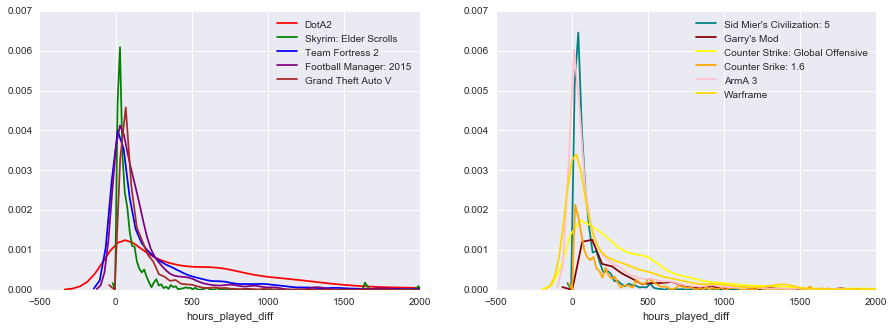

In [16]:
# Distributions of difference in hours played by post_date, for all games
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig = fig.gca()
ax1.set_xlim(-500, 2000)
ax2.set_xlim(-500, 2000)
ax1 = sns.distplot(dota_with_time_nonan_test['hours_played_diff'], color='red', hist=False, label='DotA2', ax=ax1)
ax1 = sns.distplot(elder_with_time_nonan_test['hours_played_diff'], color='green', hist=False, label='Skyrim: Elder Scrolls', ax=ax1)
ax1 = sns.distplot(tf2_with_time_nonan_test['hours_played_diff'], color='blue', hist=False, label='Team Fortress 2', ax=ax1)
ax1 = sns.distplot(fbm_with_time_nonan_test['hours_played_diff'], color='purple', hist=False, label='Football Manager: 2015', ax=ax1)
ax1 = sns.distplot(gta_with_time_nonan_test['hours_played_diff'], color='brown', hist=False, label='Grand Theft Auto V', ax=ax1)
ax1 = sns.distplot(civ_with_time_nonan_test['hours_played_diff'], color='teal', hist=False, label="Sid Mier's Civilization: 5", ax=ax2)
ax2 = sns.distplot(gmod_with_time_nonan_test['hours_played_diff'], color='maroon', hist=False, label="Garry's Mod", ax=ax2)
ax2 = sns.distplot(csgo_with_time_nonan_test['hours_played_diff'], color='yellow', hist=False, label='Counter Strike: Global Offensive', ax=ax2)
ax2 = sns.distplot(cs_with_time_nonan_test['hours_played_diff'], color='orange', hist=False, label='Counter Srike: 1.6', ax=ax2)
ax2 = sns.distplot(arma_with_time_nonan_test['hours_played_diff'], color='pink', hist=False, label='ArmA 3', ax=ax2)
ax2 = sns.distplot(warframe_with_time_nonan_test['hours_played_diff'], color='gold', hist=False, label='Warframe', ax=ax2)
ax1 = plt.legend(loc='upper right') 
ax2 = plt.legend(loc='upper right')

Below, two very different distributions of difference in hours played for videogames.

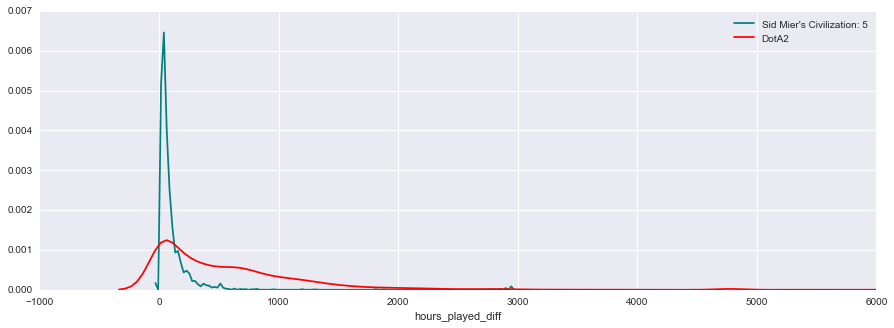

In [32]:
fig, ax = plt.subplots(figsize=(15, 5))
fig = fig.gca()
sns.distplot(civ_with_time_nonan_test['hours_played_diff'], ax=ax, color='teal', hist=False, label="Sid Mier's Civilization: 5")
sns.distplot(dota_with_time_nonan_test['hours_played_diff'], color='red', hist=False, label='DotA2', ax=ax)


#

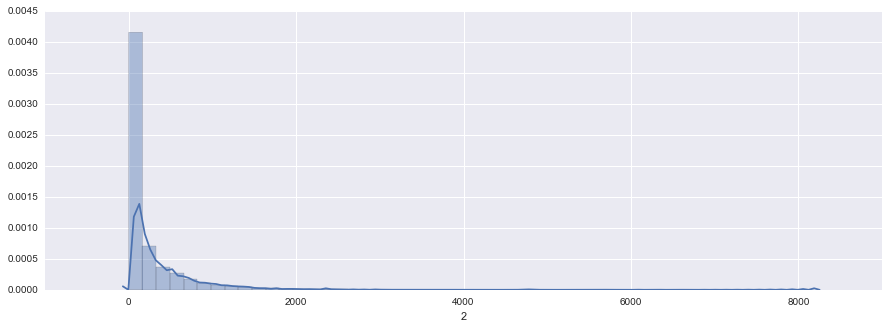

In [17]:
#distribution of difference in time played across all games
ax = plt.figure(figsize=(15, 5))
ax = sns.distplot(plott[2])

The above plot just shows the distribution for difference in hours played by a reviewer across all games.

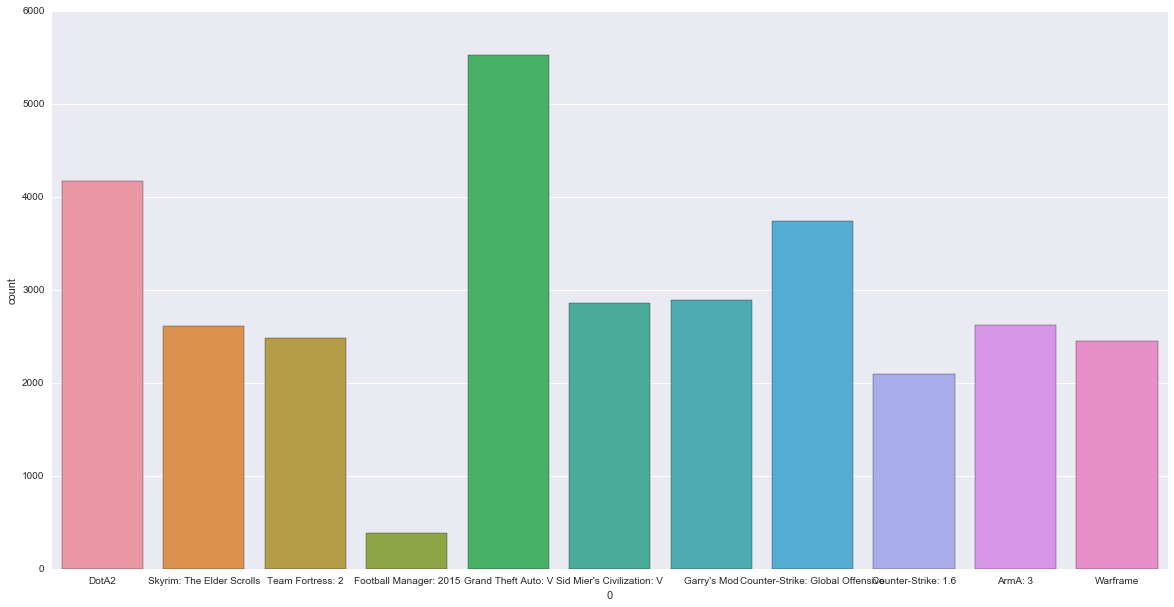

In [69]:
# Counts of reviews relative to one another
sns.set_style('darkgrid')
ax = plt.figure(figsize=(20, 10))
ax = sns.countplot(x=0, data=plott)

In [19]:
print len(plott[0])

31826


From the original dataset totalling 79,437 reviews, only 31,826 are left. Some of the user profiles in the original  dataset are unable to be retrieved, even after using the class I used from github. This won't be too big of a problem. Game '295270' won't be signifigant in my analysis as it has a fraction of the other reviews, but overall  the number of reviews across unique games is pretty similar ranging between 2000-4000. I also have an abundance of reviews for game '271590'.

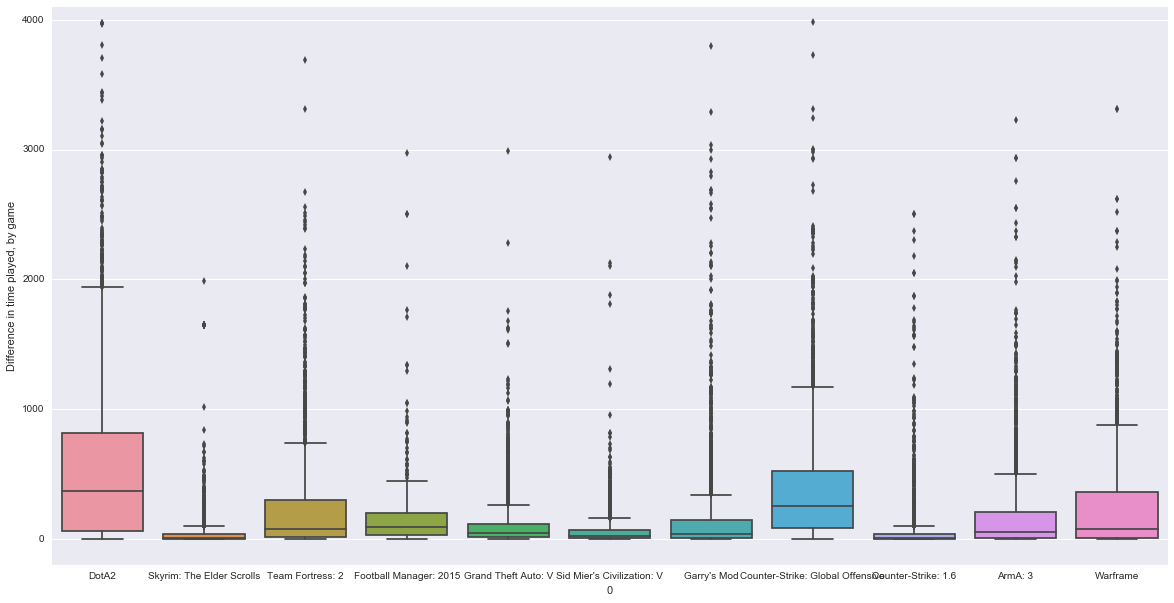

In [71]:
# Boxplot to show local maxima of difference in hours played amongst all videogames
ax = plt.figure(figsize=(20,10))
ax = plt.ylim(-200, 4100)
sns.boxplot(x=plott[0],  y=plott[2])
ax = plt.ylabel('Difference in time played, by game')

In this graph I am truncating outliers that have enormous differences in the time that they've played the game, as they are not representative of the population. Some of the games such as game 10 (Counter Strike) and 440 (Team Fortress 2) have higher differences than games like game 72850 (Skyrim) and 8930 (Sid Mier's Civilization 5) because of replayability. However Counterstrike and Team Fortress have lower differences overall because of how long ago they were released. 

With the case of Skyrim this could be due to any number of reasons as it was released November 11, 2011, Civ 5 being released September 21, 2010, whereas Counterstrike being released November 8, 2000, and Team Fortress 2 being released October 9, 2007. This is important as even years later, with the earliest review of my reviews being in 2010 there is definetly signifigance in the fact that people are still reviewing the game years after release, specifically in the case of Counterstrike.}

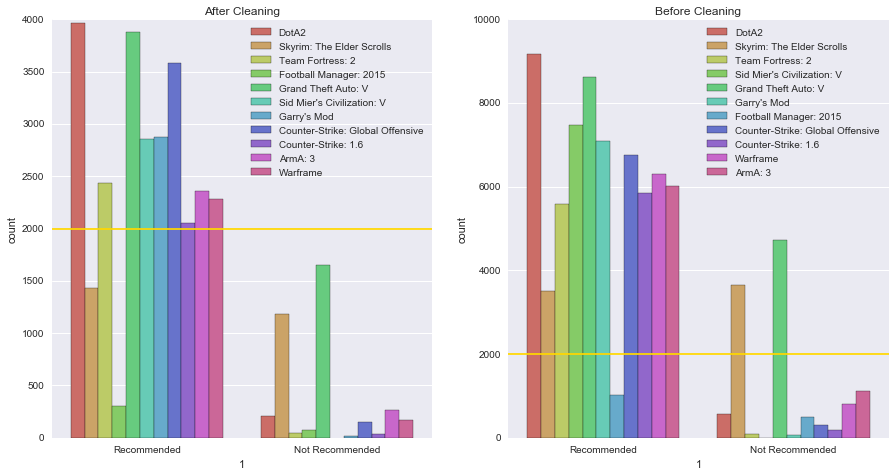

In [72]:
sns.set_style('darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7.5))
fig = plt.figure(figsize=(8,8))
ax1 = sns.countplot(x=1, data=plott, 
                    hue=0, ax=ax1, palette='hls')
ax1.set_title('After Cleaning')

# Gold lines placed at 2000 to show differences in amounts of reviews after, and before cleaning
ax1.axhline(y=2000, color='gold')
ax2 = sns.countplot(x=1, data=pre_plott, hue=0, ax=ax2, palette='hls')
ax2.set_title('Before Cleaning')
ax2.axhline(y=2000, color='gold')



Above, the class imbalance that will become more relevant later on in the report.

Recently Steam has changed their policy regarding reviews: Now, if an independant developer wishes to give out keys to a version of their game on the steam platform, the players who recieve these keys can no longer post reviews about that video game because developers were incentivising players to give more positive reviews in return for cosmetic items ingame, the keys themselves, etc. This resulted in inflation of a game's  stature on the steam store.

In [22]:
all_reviews = {
    '0':[],
    '1':[]
}

for x in eda_list:
    for index, row in x.iterrows():
        if row.rating == 'Recommended':
            all_reviews['1'].append(row['review'])
        else:
            all_reviews['0'].append(row['review'])


In [36]:
custom_stopwords = list(stopwords.words('english'))
skyrimwords = ['game', '10', 'play', 'valve', 'steam', 'like', 'skyrim', '2015', '11', 'vac', 'imo', 'mm', 'orokin', '60', 'http', 'www']
stopword_list = custom_stopwords + skyrimwords

In [37]:
cv=CountVectorizer(stop_words=stopword_list,ngram_range=(1, 2), binary=False, max_features=5000 )

In [38]:
notrecommend = cv.fit_transform(all_reviews['0'])
not_recommend_df = pd.DataFrame(notrecommend.todense(), columns=cv.vocabulary_)
print 'Most common words of all reviews not recommending the game:'
print not_recommend_df.sum().order(ascending=False)[0:10]
#Most common words of all reviews not recommending the game
print '============='
recommend = cv.fit_transform(all_reviews['1'])

#Most commmon words of all reviews recommending the game
recommend_df = pd.DataFrame(recommend.todense(), columns=cv.vocabulary_)

print 'Most common words for reviews not recommending the game'
print recommend_df.sum().order(ascending=False)[0:10]

Most common words of all reviews not recommending the game:
random             1935
system             1292
24                 1237
grace              1061
city               1008
fun multiplayer     890
pay wall            848
include             817
sale summer         816
lore                748
dtype: int64


/home/dsi-student/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: order is deprecated, use sort_values(...)


Most common words for reviews not recommending the game
gtx 970         6946
safe            5657
lord            5562
make good       5224
limited         5054
making          4763
calls silver    4399
speak           4289
possiblities    3568
gamemode        3517
dtype: int64


/home/dsi-student/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: order is deprecated, use sort_values(...)


In [39]:
cv=CountVectorizer(stop_words=stopword_list,ngram_range=(2, 2), binary=False, max_features=5000 )
fbm = cv.fit_transform(fbm_with_time_nonan_test['review'])
lowest_review_count = pd.DataFrame(fbm.todense(), columns=cv.vocabulary_)
#Most common words from smallest dataset (Football Manager)

print 'FOOTBALL MANAGER'
print lowest_review_count.sum().order(ascending=False)[0:10]
print '============='

gta = cv.fit_transform(gta_with_time_nonan_test['review'])
#Most common words from largest dataset (Grand Theft Auto)
highest_review_count = pd.DataFrame(gta.todense(), columns=cv.vocabulary_)

print 'GRAND THEFT AUTO'
print highest_review_count.sum().order(ascending=False)[0:10]

FOOTBALL MANAGER
much adding              81
physical disabilities    58
mode example             20
new product              17
went back                17
regular players          16
presenting extremely     14
shown one                14
promises want            13
year old                 11
dtype: int64


/home/dsi-student/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: order is deprecated, use sort_values(...)


GRAND THEFT AUTO
recent patch           488
rockstar continues     480
story fun              374
low fov                339
came back              328
need get               205
everywhere online      204
end hardware           181
singleplayer much      177
something different    172
dtype: int64


/home/dsi-student/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: order is deprecated, use sort_values(...)


In [40]:
cv=CountVectorizer(stop_words=stopword_list,ngram_range=(2, 2), binary=False, max_features=5000 )
counterstrike = cv.fit_transform(cs_with_time_nonan_test['review'])
#Most common words from the game with highest mean sentiment rating
highest_sentiment = pd.DataFrame(counterstrike.todense(), columns=cv.vocabulary_)
print 'COUNTER-STRIKE'
print highest_sentiment.sum().order(ascending=False)[0:10]
print '============='
skyrim = cv.fit_transform(elder_with_time_nonan_test['review'])
#Most common words from the game with lowest mean sentiment rating
lowest_sentiment = pd.DataFrame(skyrim.todense(), columns=cv.vocabulary_)

print 'SKYRIM'
print lowest_sentiment.sum().order(ascending=False)[0:10]

COUNTER-STRIKE
girls getting      279
never unstall       99
never community     85
though ages         85
went look           81
planning buy        75
ypur going          74
one thing           66
fully recommend     53
purest first        49
dtype: int64


/home/dsi-student/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: order is deprecated, use sort_values(...)


SKYRIM
compared oblivion    500
community posts      330
humps still          176
long enough          135
tes less             119
commands increase    114
mods avoid           103
kahjiit thief         80
still hero            79
interest direly       62
dtype: int64


/home/dsi-student/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: order is deprecated, use sort_values(...)


# 5. Description of model choice

Being able to depict whether or not there is a relationship between the amount of hours a user has played a videogame and the valence of the review they wrote is a very cut-and-dried task. Doing this with a linear regression is quick and easy, it also gives me a simple way to determine whether or not there is a relationship. However this is very subjective due to the fact of my sentiment rating being depcited by a third party module.


# 6. Models

For the sake of maintaining relevance I will only fit and plot on one of the datasets, there are only miniscule differences between each of them when it comes to the difference in hours played and the sentiment score of each review.

### Linear Regression

In [151]:
lr = LinearRegression(normalize=True)

ss = StandardScaler()

formula = 'hours_played_diff ~ sentiment + yearbymonth'

y, x    = patsy.dmatrices(formula, data=dota_with_time_nonan_test, return_type='dataframe')

# Standard Scaler because I'm comparing enormous values to a rating between -1, and 1
Xn = ss.fit_transform(x)

In [152]:
x_train, x_test, y_train, y_test = train_test_split(Xn, y, test_size=0.25)

In [153]:
lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [154]:
print 'lr score:', lr.score(x_test, y_test)

lr score: 0.00500970728743


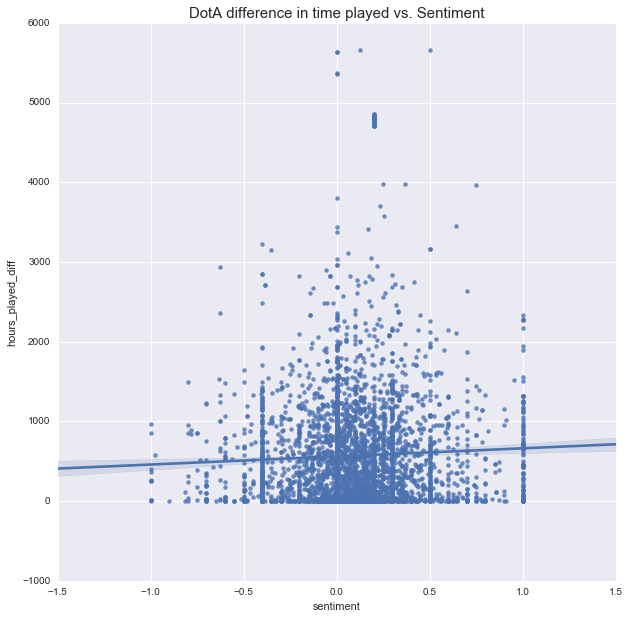

In [74]:
ax = plt.figure(figsize=(10,10))
ax = sns.regplot(x=dota_with_time_nonan_test.sentiment, y=dota_with_time_nonan_test.hours_played_diff)
plt.title('DotA difference in time played vs. Sentiment', fontsize=15)

# 7. Description of results

The regression R^2 score for all games lies around 0.00~ and thus, using the sentiment rating provided by textblob, there is no observable relationship what-so-ever between the amount a user played a videogame following their review, and the sentiment of that review. I believe if there were any relationship at all, the score of my model would diverge from 0, regardless of textblob's sentiment score as the scores each review recieves are somewhat relative.

From the regplot we can see there are users on both ends of the spectrum, with sentiment scores for their review below zero and more than 1000 additional hours played, and the latter, with sentiment ranging greater than 0.5 and still the additional hours played not exceeding 1000.

These are also very intersting results as there seems to be a pretty even spread amongst the points mapping the difference in hours played and the sentiment of the review, regardless of the class imbalance.

# 8. Conclusions about Sentiment

Looking at the linear regression we can see there is no apparent relationship between the sentiment of one's review and the amount they play the game that they review, following the review. It is probably the case that the amount someone has played is more related with how much they played the videogame at the time of reviewing, versus how positive or negative the review itself is, this doesn't say a lot about prospective success for a video game.

# #Part-2 Event Specific Reviews

# 1. Problem Statement

Looking at the class imbalance stated before, there are two games that have a decent distribution of classes, those games are 72850 (Skyrim), 271590 (Grand Theft Auto V). Fitting text analytical models against other game datasets would be problematic as there are so few numbers of reviews that don't recommend the game, compared to the amount of reviews that recommend the game.

This intrigued me to follow the scraped data back to the back to the function and see whether or not Matt Mulholland had set some kind of a condition on his scraping function that would produce such a class imbalance, however there were no indications of conditions, in fact, his scraping function very blindly looks and grabs the reviews for each game without any decision regarding whether or not the review is recommending the game.

# 2. Description of model choice

In order to depict differences between the reviews that recommend and don't recommend the videogame I will use Naive Bayes to predict the likelihood of words appearing in the two different classes of review. This is so I can get immediate results without having to take multiple passes of the data, using a count vectorizer or TFIDF vectorizer I will get a better corpus for determining common topics amongst the two classes versus using an LDA model. Before deciding completely on the Naive Bayes model I did consider using LDA however it would create issues as the class imbalance would create a lot of noise within the topics, as well as the subject expertise that woulud be required to determine what the topics across the different games would mean. In some cases Naive Bayes isn't a choice model as it assumes independance of observations, or in my case, the reviews, however this is not a problem as there is so many different factors surrounding user reviews that we can assume that they are all independant of one another.

# 3. Models

### a. Skyrim

In [41]:
custom_stopwords = list(stopwords.words('english'))
skyrimwords = ['game', '10', 'play', 'valve', 'steam', 'like', 'skyrim']
stopword_list = custom_stopwords + skyrimwords

In [42]:
cv= CountVectorizer(stop_words=custom_stopwords, ngram_range=(1, 2), binary=True, max_features=5000)
words = cv.fit_transform(elder_with_time_nonan_test.review)

In [43]:
words_df = pd.DataFrame(words.todense(), columns=cv.get_feature_names())

In [44]:
xtrain, xtest, ytrain, ytest = train_test_split(words_df.values, elder_with_time_nonan_test.rating.values, test_size=0.25)

In [45]:
nb = BernoulliNB()

nb.fit(xtrain, ytrain)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [46]:
baseline = []
# To get baseline for model
for x in ytrain:
    if x == 'Recommended':
        baseline.append(1)
    else:
        baseline.append(0)

In [47]:
nb_scores = cross_val_score(BernoulliNB(), xtrain, ytrain, cv=5)
print nb_scores
print np.mean(nb_scores)

# Baseline
print np.mean(baseline)

[ 0.74489796  0.73469388  0.76020408  0.76923077  0.74615385]
0.75103610675
0.546012269939


In [37]:
feat_lp = nb.feature_log_prob_
recommend_p = np.exp(feat_lp[1])
not_recommend_p = np.exp(feat_lp[0])
feat_probs = pd.DataFrame({'Recommend':recommend_p, 'Not Recommend':not_recommend_p, 'feature':words_df.columns.values})
feat_probs.sort_values('Not Recommend', ascending=False, inplace=True)
feat_probs.head(10)

,Not Recommend,Recommend,feature
2859,0.693348,0.244175,mods
1611,0.494927,0.604846,game
3242,0.422773,0.030755,paid
3247,0.330327,0.026095,paid mods
4671,0.293123,0.012116,valve
438,0.234498,0.049394,bethesda
3273,0.200676,0.014911,pay
2807,0.199549,0.106244,mod
4024,0.165727,0.317801,skyrim
2845,0.156708,0.082013,modding


With the features list we can easily see a pattern of reviews that don't recommend the game talking about 'paid mods' this is directly related with the game creators, Bethesda, making modifications to their game under any circumstance an expense. This causes much controversy as there are many games on steam which allow users to modify the game for free, as well as use other user's created modifications for free.

I believe this is no more than a knee-jerk reaction by the community in response to mods not being free anymore.

In [49]:
elder_during_sale = elder_with_time_nonan_test[(elder_with_time_nonan_test['date_posted'] > pd.to_datetime('03/01/2015') )& (elder_with_time_nonan_test['date_posted'] < pd.to_datetime('09/01/2015'))]

elder_during_sale.index = elder_during_sale['date_posted']

Below, the reviews given to Skyrim in the month of April, when Steam discontinued free mods for Skyrim.

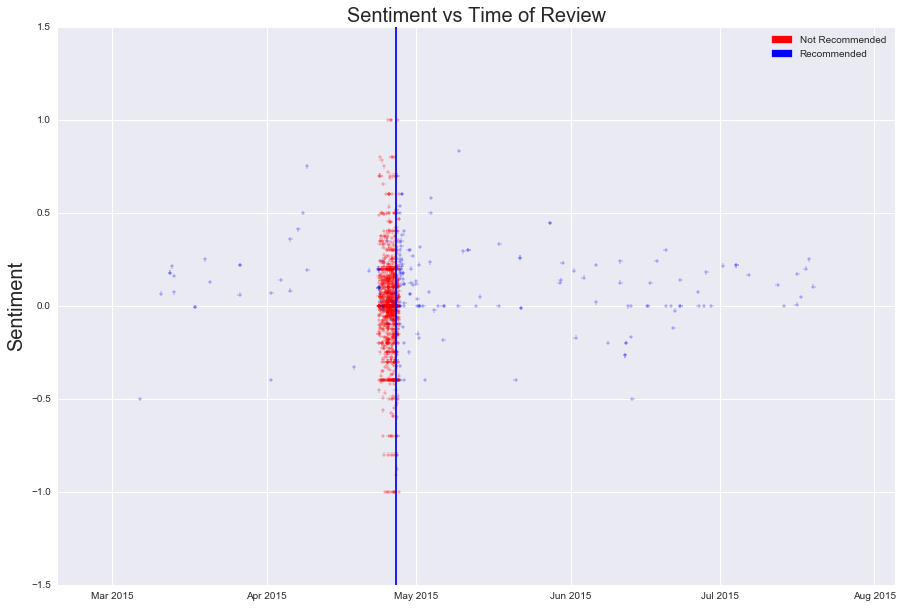

In [51]:
fig, ax = plt.subplots(figsize=(15, 10))

c_map = {'Recommended':'b', 'Not Recommended':'r'}
ax = plt.scatter(y=elder_during_sale['sentiment'], x=elder_during_sale.index, marker='+', c=[c_map[c] for c in elder_during_sale.rating])

red_patch = mpatches.Patch(color='red', label='Not Recommended')
blue_patch = mpatches.Patch(color='blue', label='Recommended')
plt.legend(handles=[red_patch, blue_patch])

plt.ylabel('Sentiment', fontsize=20)

plt.axvline(pd.to_datetime('04/27/2015'))
plt.title('Sentiment vs Time of Review', fontsize=20)

The above line shows when valve removed paid mods from Skyrim, thus, the flurry of reviews ceases. 

### b. Grand-Theft Auto

In [38]:
custom_stopwords = list(stopwords.words('english'))
gtawords = ['game', '10', 'play', 'valve', 'steam', 'like', 'grand', 'theft', 'auto', 'gta']
stopword_list = custom_stopwords + skyrimwords

In [39]:
cv= CountVectorizer(stop_words=custom_stopwords, ngram_range=(1, 2), binary=True, max_features=5000)
words = cv.fit_transform(gta_with_time_nonan_test.review)

In [40]:
words_df = pd.DataFrame(words.todense(), columns=cv.get_feature_names())

In [41]:
xtrain, xtest, ytrain, ytest = train_test_split(words_df.values, gta_with_time_nonan_test.rating.values, test_size=0.25)

In [42]:
nb = BernoulliNB()

nb.fit(xtrain, ytrain)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [43]:
baseline = []

for x in ytrain:
    if x == 'Recommended':
        baseline.append(1)
    else:
        baseline.append(0)

In [44]:
nb_scores = cross_val_score(BernoulliNB(), xtest, ytest, cv=5)
print nb_scores
print np.mean(nb_scores)

# Baseline
print  1 - np.mean(baseline)

[ 0.77978339  0.77978339  0.77978339  0.81588448  0.75636364]
0.782319658681
0.304148576942


In [45]:
feat_lp = nb.feature_log_prob_
recommend_p = np.exp(feat_lp[1])
not_recommend_p = np.exp(feat_lp[0])
feat_probs = pd.DataFrame({'Recommend':recommend_p, 'Not Recommend':not_recommend_p, 'feature':words_df.columns.values})
feat_probs.sort_values('Not Recommend', ascending=False, inplace=True)
feat_probs.head(10)

,Not Recommend,Recommend,feature
1590,0.676168,0.547627,game
3846,0.399050,0.127468,rockstar
3277,0.257324,0.087634,people
3938,0.257324,0.019397,sale
3513,0.254157,0.023900,price
2048,0.251781,0.233114,gta
3094,0.230404,0.201247,online
1851,0.217736,0.148597,get
2898,0.203484,0.066159,money
2543,0.201900,0.142362,like


In [248]:
gta_ratio['rating'].value_counts()

Recommended        8613
Not Recommended    4736
Name: rating, dtype: int64

In [249]:
gta_during_sale['rating'].value_counts()

Recommended        3879
Not Recommended    1650
Name: rating, dtype: int64

In [23]:
# gta_ratio = gta_df[(pd.to_datetime(gta_df['date_posted']) > pd.to_datetime('03/01/2015') )& (pd.to_datetime(gta_df['date_posted']) < pd.to_datetime('05/01/2015'))]
# Three months after game being released


gta_during_sale = gta_with_time_nonan_test[(gta_with_time_nonan_test['date_posted'] > pd.to_datetime('03/01/2015') )& (gta_with_time_nonan_test['date_posted'] < pd.to_datetime('09/01/2015'))]

gta_ratio = gta_df.copy()


gta_during_sale.index = gta_during_sale['date_posted']


print gta_during_sale['rating'].value_counts()[1] *1. / gta_ratio['rating'].value_counts()[1]*1.


0.34839527027


 As seen above, this period accounts for 34% of all the observed reviews that don't recommend the game.


This is of all the reviews, not just the reviews I was able to retrieve results for from the steam API

In [24]:
gta_during_sale.rating.value_counts()

Recommended        3879
Not Recommended    1650
Name: rating, dtype: int64

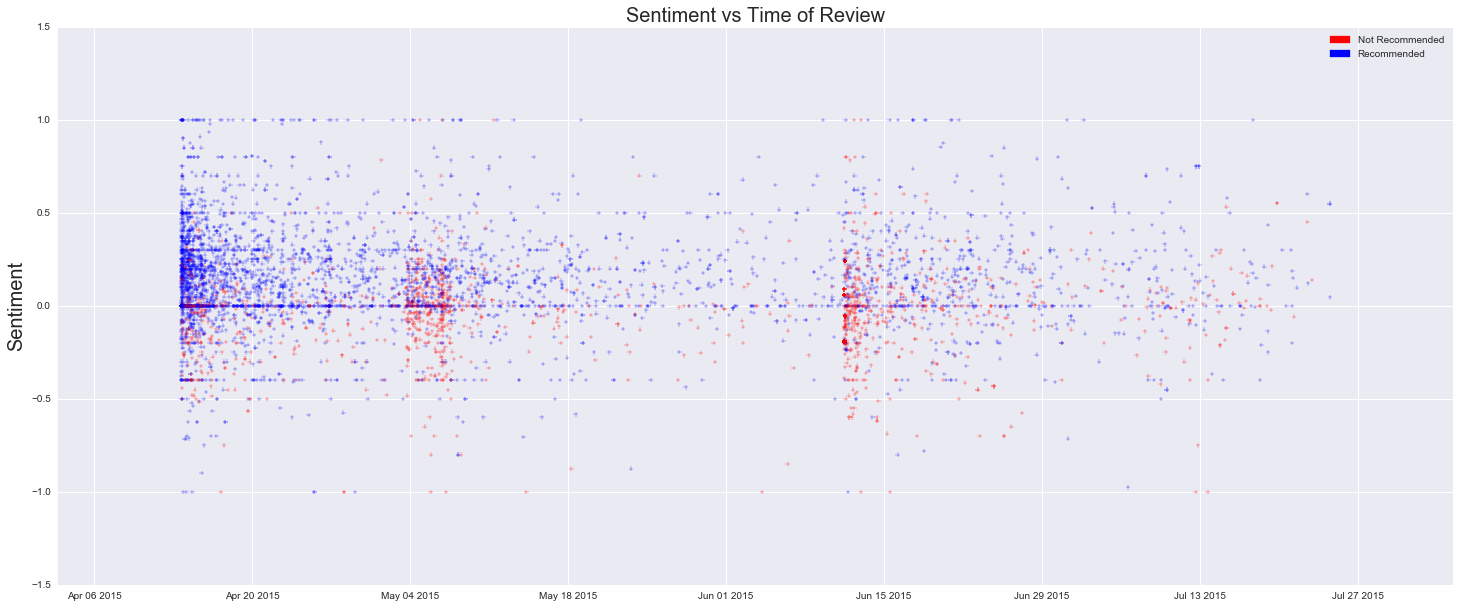

In [29]:
fig, ax = plt.subplots(figsize=(25, 10))

c_map = {'Recommended':'b', 'Not Recommended':'r'}
ax = plt.scatter(y=gta_during_sale['sentiment'], x=gta_during_sale.index, marker='+', c=[c_map[c] for c in gta_during_sale.rating], label={'b':'Recommended', 'r':'Not Recommended'})
red_patch = mpatches.Patch(color='red', label='Not Recommended')
blue_patch = mpatches.Patch(color='blue', label='Recommended')
plt.legend(handles=[red_patch, blue_patch])

plt.ylabel('Sentiment', fontsize=20)
plt.title('Sentiment vs Time of Review', fontsize=20)

Above we can see the large amount of reviews that happen at different intervals across the lifespan of the videogame. The red points indicating when users don't recommend grand theft auto, the blue points recommending the game. 

Driven by the result of the previous model, I was interested in why 'price', 'sale', and more importantly the company's name, 'rockstar', were more likely to apear in the reviews that don't recommend Grand Theft Auto;  as it turns out, when the game was released in April of 2015, this was right in the middle of a "Steam Summer Sale" in which players can buy all of the games they've kept their eye on at a cheaper price.

Players thought they had found a discounted Grand Theft Auto 5, however what they got was a marked up price, discounted, almost to the original price of the game, and even at that, it wasn't the game itself, but ingame points that were discounted. Similar to the previous model, this shows the reaction from the community in response to the game being unpurchasable, even though it wasn't the game company itself that made the mistake, they suffered the consequences, and by 'rockstar' appearing highly in the features list it shows that the players had no context to who had marked the game down, when in reality it was Valve, not Rockstar Games.

# 7. Description of results

Under both games we can see a likelihood of words in reviews that dont recommend the game that relate to decisions made by Steam or in some cases, the developers themselves. Perhaps the topics talked about in reviews pertain specifically to what surrounds the game and the community of the game at the time of the review being posted.

In order to test this I will perform another Naive Bayes Classification on the DotA 2 reviews I have, predicting the specific times in which it's biggest tournament of the year, The International, is happening. However, different from the previous models I use multinomial naive bayes to take into account all of the words being used, not just the occurence of the words.

In [58]:
dota_df['date_posted'] = pd.to_datetime(dota_df['date_posted'])
# This is a subset of the original review data, so there are no exclusions due to the profile being unretrievable

#03/09/2014 is two months before the prize pool for the international opened up, 09/21/2014 is two months after the international concluded.
dota_international_2014_lr = dota_df[(dota_df['date_posted'] >= pd.to_datetime('03/09/2014')) & (dota_df['date_posted'] <= pd.to_datetime('09/21/2014'))]

dota_international_2014_lr['tourneytime'] = dota_international_2014_lr['date_posted'].map(lambda x: 1 if (x >= pd.to_datetime('05/09/2014')) & (x <= pd.to_datetime('07/21/2014')) else 0)

/home/dsi-student/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [171]:
custom_stopwords = list(stopwords.words('english'))
common_stopwords = ['game', '10', 'play', 'valve', 'steam', 'like', 'dota']
stopword_list = custom_stopwords + common_stopwords

From game to game these stop words change because of the specific dialogue that is expressed in the reviews.

In [221]:
cv_i = TfidfVectorizer(stop_words=stopword_list, ngram_range=(2, 2), binary=False, max_features=6000)
words_i = cv_i.fit_transform(dota_international_2014_lr.review)
international_words = pd.DataFrame(words_i.todense(), columns=cv_i.get_feature_names())

In [222]:
xtrain, xtest, ytrain, ytest = train_test_split(international_words.values, dota_international_2014_lr.tourneytime.values, test_size=0.25)

In [223]:
inb = MultinomialNB()

In [224]:
inb.fit(xtrain, ytrain)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [225]:
nb_scores = cross_val_score(MultinomialNB(), xtest, ytest, cv=10)
print nb_scores
print np.mean(nb_scores)

#Baseline
print 1 - np.mean(ytest)

[ 0.56565657  0.5959596   0.60204082  0.55670103  0.59793814  0.63917526
  0.58762887  0.54639175  0.6185567   0.63917526]
0.594922398825
0.567179487179


In [226]:
feat_lp = inb.feature_log_prob_
recommend_p = np.exp(feat_lp[1])
not_recommend_p = np.exp(feat_lp[0])
feat_probs = pd.DataFrame({'During International':recommend_p, 'Not During International':not_recommend_p, 'feature':international_words.columns.values})
feat_probs.sort_values('During International', ascending=False, inplace=True)
feat_probs.head(10)

,During International,Not During International,feature
170,0.002049,0.003642,best ever
177,0.001930,0.001054,best moba
1058,0.001521,0.002020,ever played
196,0.001280,0.000281,best world
203,0.001229,0.000563,better lol
4442,0.001222,0.001726,ruined life
5913,0.001151,0.000664,would recommend
2824,0.001060,0.001056,learning curve
3310,0.000973,0.001187,one best
4423,0.000954,0.000301,rosetta stone


Definetly an odd observation, during the international, there arent many differences between language used pre/post, and during the international.

The feature 'ruined life' has a reasonably high tfidf-probability on both ends, sometimes appearing more frequently than other words in reviews that occurred not during the international like 'better lol', 'best world', and 'best moba'.

In [59]:
dota_international_ts = dota_international_2014_lr[(dota_international_2014_lr['date_posted'] >= pd.to_datetime('03/09/2014')) & (dota_international_2014_lr['date_posted'] <= pd.to_datetime('09/21/2014'))]

dota_international_ts.index = dota_international_ts['date_posted']

Adding sentiment rating to original dota dataframe without lost data

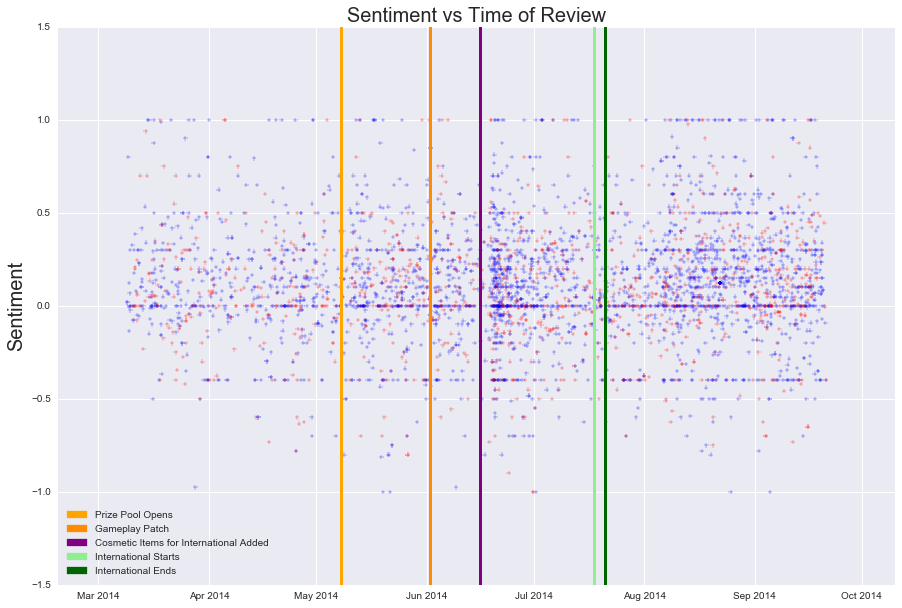

In [116]:

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

c_map = {'Recommended':'b', 'Not Recommended':'r'}
plt.scatter(y=dota_international_ts['sentiment'], x=dota_international_ts.index, marker='+', c=[c_map[c] for c in gta_during_sale.rating], label={'b':'Recommended', 'r':'Not Recommended'})
plt.plot(x=dota_international_ts.index, y=np.mean(dota_international_ts['sentiment']))

plt.axvline(pd.to_datetime('07/18/2014'), c='lightgreen', lw=3)
plt.axvline(pd.to_datetime('07/21/2014'), c='darkgreen', lw=3)
plt.axvline(pd.to_datetime('05/8/2014'), c='orange', lw=3)
plt.axvline(pd.to_datetime('06/2/2014'), c='darkorange', lw=3)
plt.axvline(pd.to_datetime('06/16/2014'), c='purple', lw=3)
# Different time intervals to show events surroundinng the international

orange = mpatches.Patch(color='orange', label='Prize Pool Opens')
darkorange = mpatches.Patch(color='darkorange', label='Gameplay Patch')
purple = mpatches.Patch(color='purple', label='Cosmetic Items for International Added')
lightgreen = mpatches.Patch(color='lightgreen', label='International Starts')
darkgreen = mpatches.Patch(color='darkgreen', label='International Ends')
plt.legend(handles=[orange, darkorange, purple, lightgreen, darkgreen], loc='lower left')

plt.ylabel('Sentiment', fontsize=20)
plt.title('Sentiment vs Time of Review', fontsize=20)



We can see, unlike the other previous graphs, during the international  there is only a slight pickup in the amount of reviews that are posted in response to the international. This indicates that people are more likely to post a review following a bad event, rather than a goood one.

In [227]:
predictions = inb.predict(xtest)
print classification_report(ytest, predictions)
confmat = confusion_matrix(y_true=ytest, y_pred=inb.predict(xtest))

confusion = pd.DataFrame(confmat, index=['is not tourneytime', 'is tourneytime'],
                         columns=['predicted is not tourneytime','predicted is tourneytime'])

confusion

             precision    recall  f1-score   support

          0       0.61      0.87      0.72       553
          1       0.61      0.26      0.36       422

avg / total       0.61      0.61      0.56       975



,predicted is not tourneytime,predicted is tourneytime
is not tourneytime,483,70
is tourneytime,314,108


In [228]:
fpr = dict()
tpr = dict()

fpr[1], tpr[1], thresh = roc_curve(ytrain, inb.predict_proba(xtrain)[:,1])
fpr[2], tpr[2], thresh = roc_curve(ytest, inb.predict_proba(xtest)[:,1])

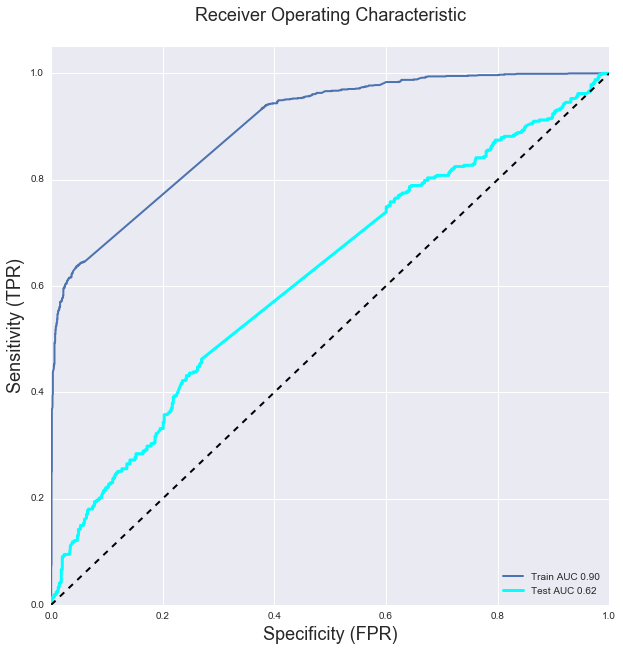

In [229]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

roc_auc = auc(fpr[1], tpr[1])
ax = plt.plot(fpr[1], tpr[1], lw=2,
             label='Train AUC '+'{0:.2f}'.format(roc_auc))




roc_auc_2 = auc(fpr[2], tpr[2])
ax = plt.plot(fpr[2], tpr[2], lw=3, color='cyan',
              label='Test AUC '+'{0:.2f}'.format(roc_auc_2))

        
# 50 / 50 line
ax = plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Specificity (FPR)', fontsize=18)
plt.ylabel('Sensitivity (TPR)', fontsize=18)
plt.title('Receiver Operating Characteristic\n', fontsize=18)
plt.legend(loc="lower right")
plt.show()

## 8. Conclusions about event-specific reviews

More often than not, performing better than the baseline, this model shows there is not a clear distinction between reviews that happen before/after, and during festivities surounding a videogame and it's community, in the case of DotA2. Perhaps there are very small differences, my model on average performs about 3% better than the baseline, so if there are differences, they are few.

The results from the previous Naive Bayes model show what I believe is summed up as buyer's remorse. Very similar to when you go to a restaraunt, get bad service, then in response, write a yelp review of that service, updating the stature of that restaraunt accordingly, these players felt neglected in some way and thus posted reviews to update Bethesda's or Rockstar Games' stature. 

I definetly believe there are more conclusions to be made about how a video game company's behavior in the public eye can effect it's reviews both on the side of topics and nature of those topics, and on the side of sentiment. However change in sentiment is not related to the change in hours a reviewer has played the videogame they reviewed.

# Beyond this Project

To predict the **potential** success of a videogame from beta I would require a larger corpus of game reviews that were in beta and both succeeded after release and didn't succeed after release. Then with finer tuning of my text analysis I would be able to determine differences between the reviews of both cases and the distinguishing factors that indicate future prosperity.